In [1]:
# import some code that we'll need
import numpy as np
import sys
import math
import pandas as pd
sys.path.append('../../')
import bayesim.model as bym
import bayesim.params as byp
import deepdish as dd
from copy import deepcopy
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
m = bym.Model(obs_data_path='obs_data.h5', model_data_path='SCAPS_data_sparse.h5', output_var='J', ec_x_var='V', calc_model_unc=True)
m.set_param_units('V', 'V')
m.set_param_units('T', 'K')
m.set_param_units('J', 'mA/cm^2')
m.set_param_units('EA', 'eV')
m.set_param_units('Nt_i', 'cm^-3')
m.set_param_units('Nt_SnS', 'cm^-2')
m.set_param_units('mu', 'cm^2/Vs')

Adding the variable V to the list of experimental conditions and setting it as the x-axis variable for plotting.
Determining experimental conditions from observed data...
Identified experimental conditions as ['V', 'T', 'ill']. If this is wrong, rerun and explicitly specify them with attach_ec (make sure they match data file columns) or remove extra columns from data file.
Determining fitting parameters from modeled data...
Setting min_width automatically for EA.
Setting min_width automatically for Nt_i.
Setting min_width automatically for mu.
Setting min_width automatically for Nt_SnS.
Found fitting parameters: ['EA', 'Nt_i', 'mu', 'Nt_SnS']
Rounding model data...


In [38]:
m.run(min_num_pts=len(m.obs_data))

Did a total of 92 runs to use a total of 120 observations.

An average of 212 / 256 probability points had larger model uncertainty than experimental uncertainty during this run.


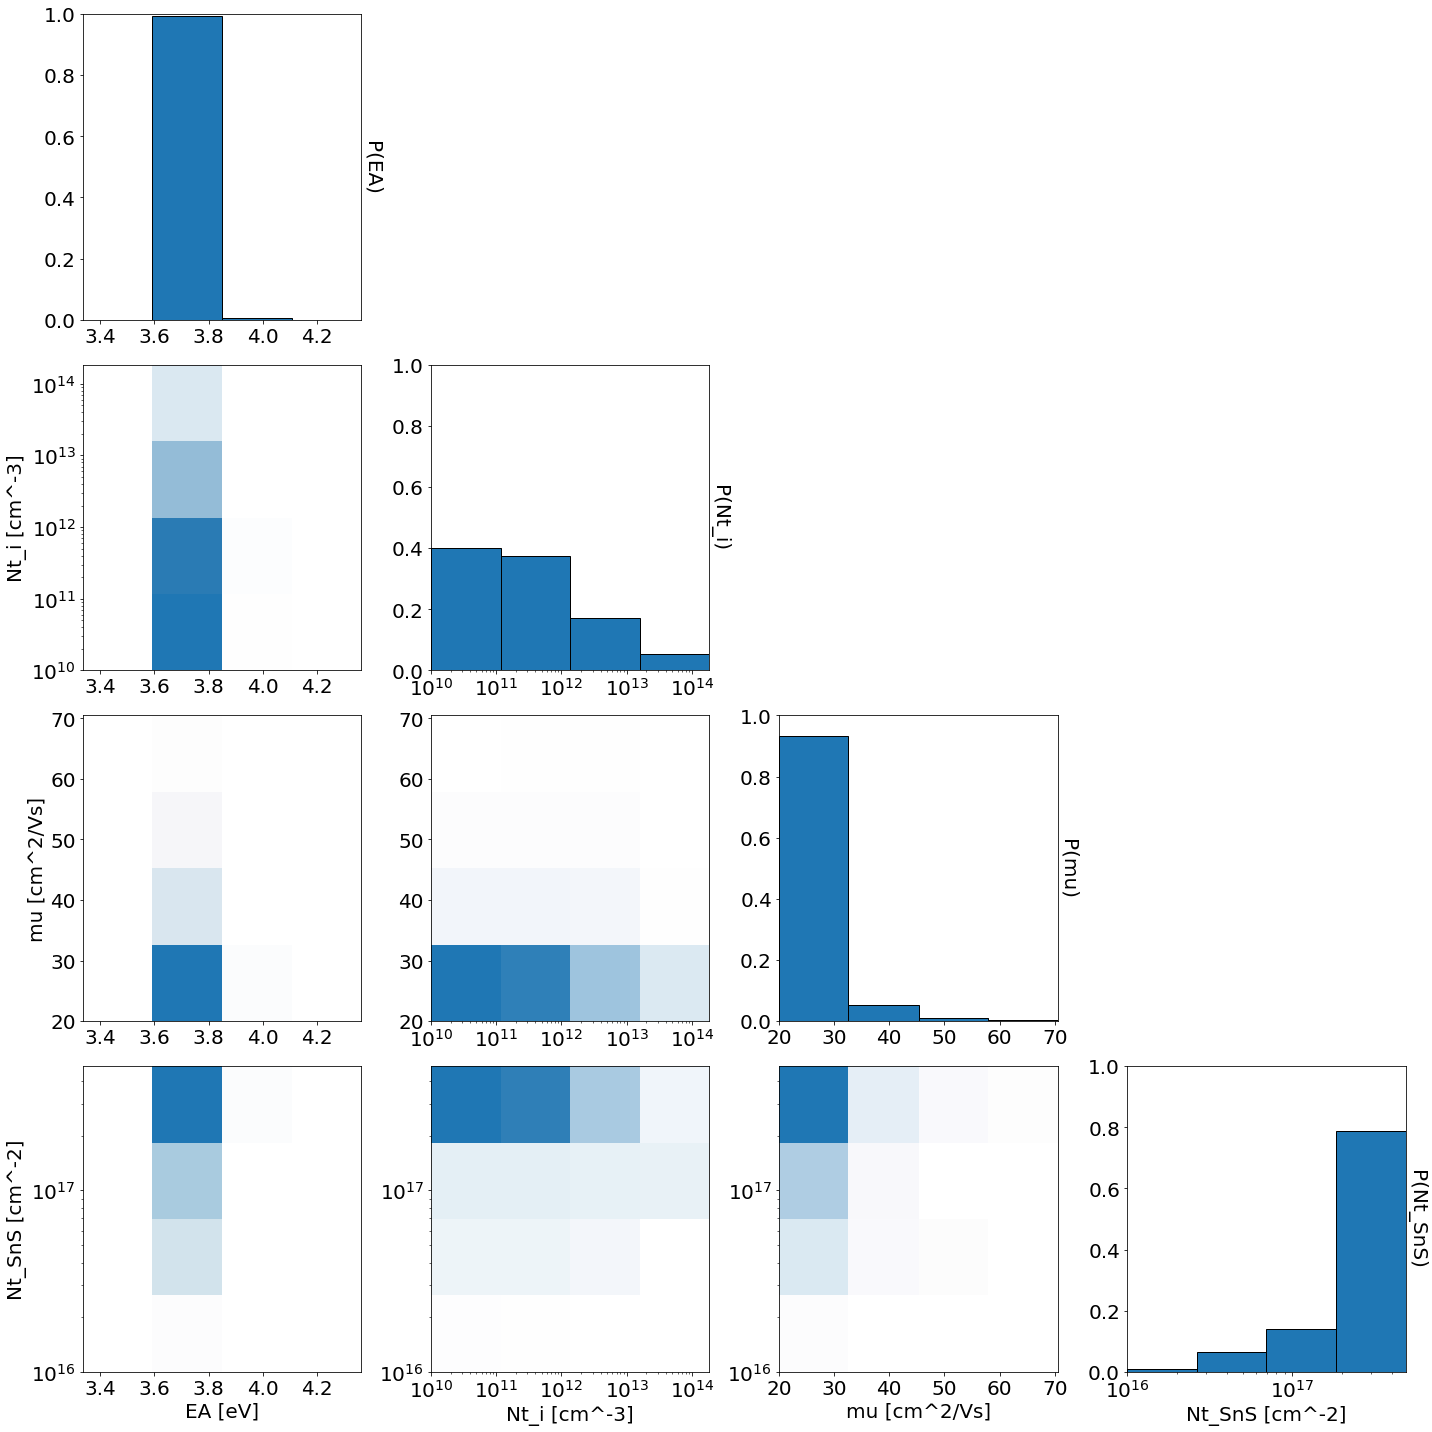

In [39]:
m.visualize_probs()

In [ ]:
#m.save_state('after_run_1.h5')
#m = bym.Model(load_state=True, state_file='after_run_1.h5')

In [40]:
m.subdivide()

28 box(es) with probability > 0.001 and 147 neighboring boxes subdivided!
Overwriting metadata for fitting parameter EA with new info.
Overwriting metadata for fitting parameter Nt_i with new info.
Overwriting metadata for fitting parameter mu with new info.
Overwriting metadata for fitting parameter Nt_SnS with new info.
New model points to simulate are saved in the file new_sim_points_1.h5.


In [ ]:
m.visualize_grid()

In [ ]:
#m.save_state('after_subdivide.h5')
#m = bym.Model(load_state=True, state_file='after_subdivide.h5')

In [42]:
get_new_data('SCAPS_sims_sorted_trimmed.h5', 'new_sim_points_1.h5', 'new_sim_data.h5')
m.attach_model(mode='file', model_data_path='new_sim_data.h5', calc_model_unc=True)

Rounding model data...


In [ ]:
m.save_state('with_new_data.h5')
#m=bym.Model(load_state=True, state_file='with_new_data.h5')

In [43]:
m.run(min_num_pts=len(m.obs_data),th_pv=0.02)

Did a total of 96 runs to use a total of 120 observations.

An average of 1688 / 2800 probability points had larger model uncertainty than experimental uncertainty during this run.


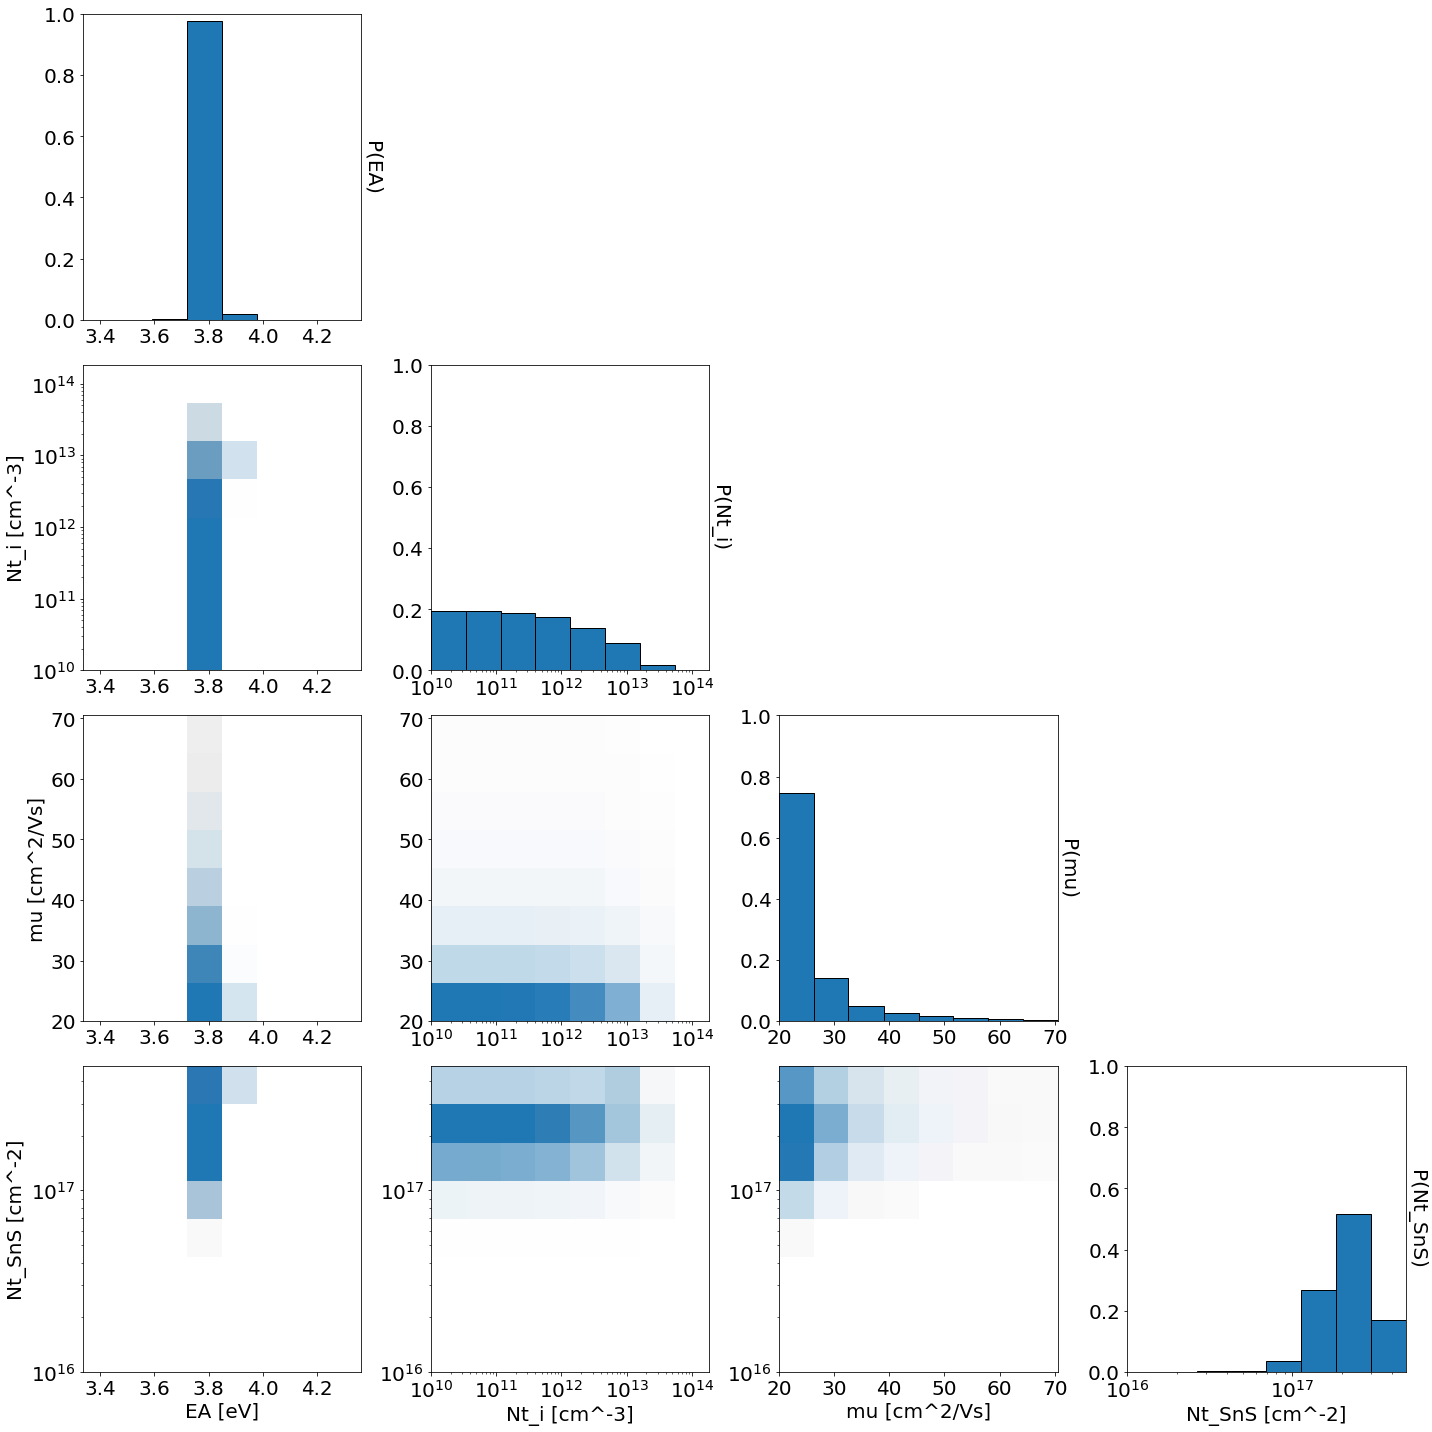

In [44]:
m.visualize_probs()

In [41]:
def get_new_data(all_data_path, new_pts_path, new_data_path):
    from copy import deepcopy
    new_pts = dd.io.load(new_pts_path)
    all_data = dd.io.load(all_data_path)
    new_grps = new_pts.groupby(m.fit_param_names())
    all_grps = all_data.groupby(m.fit_param_names())

    new_EA = sorted(list(set(new_pts['EA'])))
    new_Nt_i = sorted(list(set(new_pts['Nt_i'])))
    new_mu = sorted(list(set(new_pts['mu'])))
    new_Nt_SnS = sorted(list(set(new_pts['Nt_SnS'])))
    new_lists = [new_EA, new_Nt_i, new_mu, new_Nt_SnS]
    
    all_EA = sorted(list(set(all_data['EA'])))
    all_Nt_i = sorted(list(set(all_data['Nt_i'])))
    all_mu = sorted(list(set(all_data['mu'])))
    all_Nt_SnS = sorted(list(set(all_data['Nt_SnS'])))
    old_lists = [all_EA, all_Nt_i, all_mu, all_Nt_SnS]
    
    # map new values to old indices
    ind_maps = [{},{},{},{}]
    for i in range(len(new_lists)):
        for new_val in new_lists[i]:
            diffs = [abs(new_val-old_val) for old_val in old_lists[i]]
            min_ind = diffs.index(min(diffs))
            ind_maps[i][new_val] = min_ind
        diffs = np.diff(list(ind_maps[i].values()))
        if any([d==1 for d in diffs]):
            print('Might be out of range!'+str(ind_maps[i]))
        
    # map new values onto unrounded sim points
    key_map = {}
    for new_key in list(new_grps.groups.keys()):
        old_key = [-1, -1, -1, -1]
        for i in range(len(m.params.fit_params)):
            old_key[i] = old_lists[i][ind_maps[i][new_key[i]]]
        key_map[new_key] = tuple(old_key)
    keys_to_keep = key_map.values()

    new_data = deepcopy(all_data)
    inds_to_drop = []
    for key in list(all_grps.groups.keys()):
        if not key in keys_to_keep:
            inds_to_drop.extend(list(all_grps.groups[key]))
        
    new_data.drop(inds_to_drop, inplace=True)
    new_data.reset_index(drop=True, inplace=True)
    dd.io.save(new_data_path, new_data)

In [18]:
all_data = dd.io.load('SCAPS_sims_sorted_trimmed.h5')
all_EA = sorted(list(set(all_data['EA'])))
all_Nt_i = sorted(list(set(all_data['Nt_i'])))
all_mu = sorted(list(set(all_data['mu'])))
all_Nt_SnS = sorted(list(set(all_data['Nt_SnS'])))
all_grps = all_data.groupby(m.fit_param_names())

In [19]:
len(all_EA),len(all_Nt_i),len(all_mu),len(all_Nt_SnS)

(15, 16, 20, 20)

In [33]:
# building the sparse grid
EA_sparse = all_EA[1::4]
Nt_i_sparse = all_Nt_i[2::4]
mu_sparse = all_mu[2:18:4]
Nt_SnS_sparse = all_Nt_SnS[2:18:4]

In [34]:
len(EA_sparse),len(Nt_i_sparse),len(mu_sparse),len(Nt_SnS_sparse)

(4, 4, 4, 4)

In [35]:
sparse_data = deepcopy(all_data)
inds_to_drop = []
for key in list(all_grps.groups.keys()):
    if not (key[0] in EA_sparse and key[1] in Nt_i_sparse and key[2] in mu_sparse and key[3] in Nt_SnS_sparse):
        inds_to_drop.extend(list(all_grps.groups[key]))
sparse_data = sparse_data.drop(inds_to_drop).reset_index(drop=True)

In [36]:
dd.io.save('SCAPS_data_sparse.h5',sparse_data)